In [756]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import pandas as pd
import seaborn as sns
import pingouin as pg
from tqdm import tqdm

from src import data, paths, matrix_filtering, communicatin_metrics, plotting
from scipy import signal

from sklearn import metrics as sk_metrics
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

plt.style.use('ggplot')
%matplotlib inline

!date -I

2024-05-16


## Settings

In [757]:
SELECTED_SC_MATRIX = "Mica-Mics_rh"
EMPIRICAL_SIMULATED =   'simulated' # 'empirical' #
RESPONSE_LENGTH = 50
GRAPH_DENSITY = 0.25

WHEN_NOT_OVER_THRESHOLD = np.nan

In [758]:
fig_dir = f"pytepfit_results/{EMPIRICAL_SIMULATED}/{RESPONSE_LENGTH}/not_over_threshold_{str(WHEN_NOT_OVER_THRESHOLD)}/"
%mkdir -p  {paths.path_figures(fig_dir)}
results_dir = f'interim/pyTepFit_{EMPIRICAL_SIMULATED}/not_over_threshold_{str(WHEN_NOT_OVER_THRESHOLD)}/'
%mkdir -p {paths.path(results_dir)}

In [759]:
color7_dict= {'Default':'yellow', 'Limbic':'blue','SalVentAttn':'red',  'DorsAttn':'green','Vis':'purple','Cont':'orange', 'SomMot':'pink'}
legend_patches = []
for c in color7_dict:
    legend_patches.append(mpatches.Patch(color=color7_dict[c], label=c))

def plot_data(data,colors=None,title=None,stimulation_time=None):
    plt.rcParams['figure.figsize'] = [10, 5]
    fig,ax = plt.subplots()
    if colors:
        for i,d in enumerate(data.T):
            ax.plot(d,color=colors[i], alpha=0.7,)
        ax.legend(handles=legend_patches,loc='upper left', ncols=1,bbox_to_anchor=(0,-0.05,1,1))
    else:
        ax.plot(data, alpha=0.7)
    plt.xlabel("ms")
    if stimulation_time:
        ax.axvline(stimulation_time, ymin=np.min(data), ymax=np.max(data),ls=":",label="stimulation time",color="k")
    plt.title(title)
    

def plot_one_roi(data,roi_id,labels,title=None,constants_h=[],constants_v=[]):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.figure()
    plt.plot(data[:,roi_id])
    for c in constants_h:
        plt.plot([c]*data.shape[0],color="k")
    for c in constants_v:
        plt.vlines(c, np.min(data), np.max(data),color="k")
    plt.title(labels[roi_id])
    plt.xlabel("ms")
    plt.show()

## Load data

### Load pytepfit data

In [760]:
pytepfit_path = 'external/pytepfit/'
data_pytepfit = np.load(paths.path(f'{pytepfit_path}source_estimates/{EMPIRICAL_SIMULATED}.npz'))
data_pytepfit['ts'].shape

(400, 200)

In [761]:
data_pytepfit['labels'][:10]

array(['7Networks_LH_Cont_Cing_1-lh', '7Networks_LH_Cont_Cing_2-lh',
       '7Networks_LH_Cont_PFCl_1-lh', '7Networks_LH_Cont_PFCl_2-lh',
       '7Networks_LH_Cont_PFCl_3-lh', '7Networks_LH_Cont_PFCl_4-lh',
       '7Networks_LH_Cont_PFCl_5-lh', '7Networks_LH_Cont_PFCl_6-lh',
       '7Networks_LH_Cont_Par_1-lh', '7Networks_LH_Cont_Par_2-lh'],
      dtype='<U40')

In [762]:
color_based_on_yeo7 = []

for x in data_pytepfit['labels']:
    color_based_on_yeo7.append(color7_dict[x.split("_")[2]])

In [763]:
stimulation_time = 100

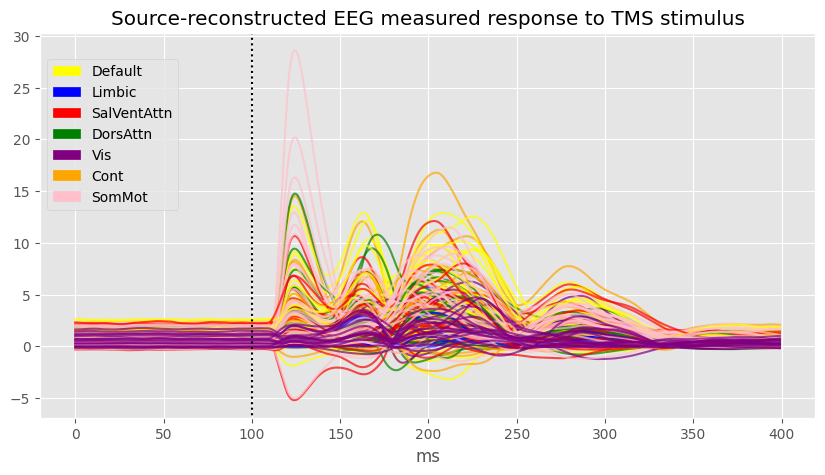

In [764]:
data_ts = data_pytepfit['ts']
plot_data(data_ts,colors=color_based_on_yeo7,stimulation_time=stimulation_time,title="Source-reconstructed EEG measured response to TMS stimulus")
plt.savefig(paths.path_figures(fig_dir+"data.pdf"),bbox_inches='tight',pad_inches=0)

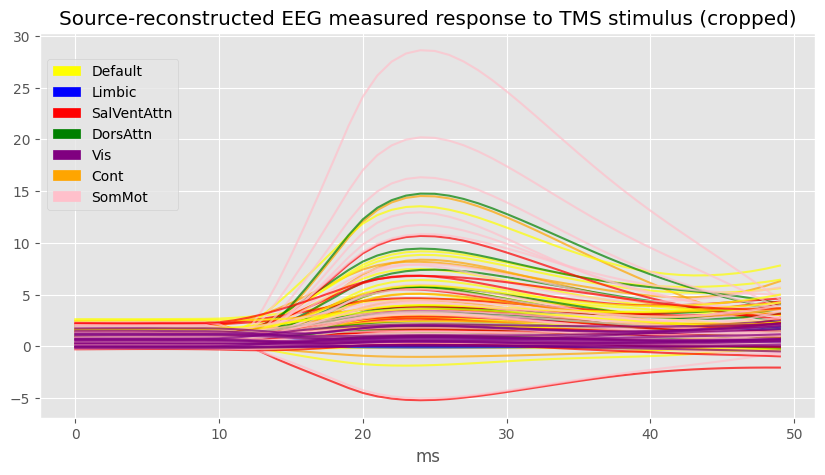

In [765]:
data_ts_croped = data_ts[stimulation_time:stimulation_time+RESPONSE_LENGTH,:]
plot_data(data_ts_croped,colors=color_based_on_yeo7,title="Source-reconstructed EEG measured response to TMS stimulus (cropped)")
plt.savefig(paths.path_figures(fig_dir+"cropped_data.pdf"),bbox_inches='tight',pad_inches=0)
plt.show()

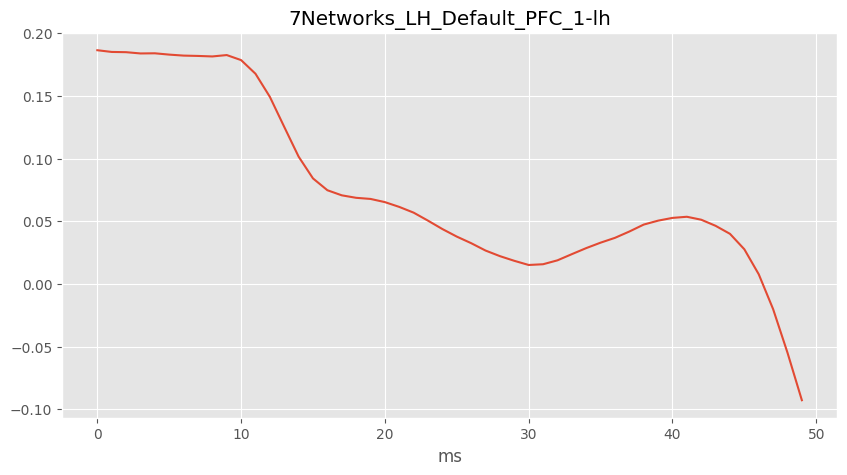

In [766]:
plot_one_roi(data_ts_croped,17,data_pytepfit['labels'])

In [767]:
def peak_analysis(sequence,threshold):
    peaks = signal.find_peaks(sequence,height=threshold)
    if len(peaks[0]) == 0:
        return np.nan, np.nan, np.nan, np.nan

    first_peak_time = peaks[0][0]
    first_peak_height = peaks[1]['peak_heights'][0]
    max_peak_time = peaks[0][np.argmax(peaks[1]['peak_heights'])]
    max_peak_height = np.max(peaks[1]['peak_heights'])

    return first_peak_time, first_peak_height, max_peak_time, max_peak_height

def estimate_auc(seqence, threshold):
    estimate = 0

    for v in seqence:
        if v > threshold:
            estimate += v

    if estimate > 0:
        return estimate

    return None
    

def get_threshold_range(data,stim_idx):
    maxima = np.max(data[stim_idx:,:],axis=0)
    print(maxima.shape)
    maxima.sort()

    upper = int(maxima[-30]) # for higest threshold there should be at least 30 responses above for statistics
    lower = int(np.max(data[:stim_idx,:]))
    step = int((upper - lower) / 7)

    if step <1:
        step = 1

    return range(lower, upper, step)

In [768]:
colors=['#E24A33', '#348ABD', '#8EBA42', '#777777','#FBC15E', '#FFB5B8', '#988ED5']

def plot_one_roi_response_definitions(data,roi_id,labels,thr):
    plt.rcParams['figure.figsize'] = [10, 5]
    selected_curve = data[:,roi_id]

    amp_id, amp, amp_h_id, amp_h = peak_analysis(selected_curve,threshold=thr)

    auc_color = colors[4]
    first_peak_color = colors[1]
    highest_peak_color = colors[0]

    plt.figure()

    plt.plot(data[:,roi_id],color=auc_color)
    plt.fill_between([i for i in range(len(selected_curve))],selected_curve,alpha=0.15,color=auc_color)
    plt.text(RESPONSE_LENGTH-20, 2, "AUC",color=auc_color,fontsize=20)

    plt.vlines(amp_id, 0, amp,color=first_peak_color)
    plt.text(amp_id+1, amp+0.5, f"first_peak = {amp:.2f}",color=first_peak_color)
    plt.plot([1]*(amp_id+1),color=first_peak_color,ls="--")
    plt.text(amp_id+1, 1+0.3, f"first_peak_time = {amp_id}",color=first_peak_color)

    plt.vlines(amp_h_id, 0, amp_h,color=highest_peak_color)
    plt.text(amp_h_id+1, amp_h+0.5, f"highest_peak = {amp_h:.2f}",color=highest_peak_color)
    plt.plot([4]*(amp_h_id+1),color=highest_peak_color,ls="--")
    plt.text(amp_h_id+1, 4+0.3, f"highest_peak_time = {amp_h_id}",color=highest_peak_color)

    ax = plt.gca()
    ax.set_ylim([0,amp_h+3])
    ax.set_xlim([0, len(selected_curve)])

    
    plt.title(f"ROI identifier: {labels[roi_id]}")
    plt.plot([thr]*len(selected_curve),color="k",ls=":")
    plt.text(len(selected_curve)-5, thr+0.3, f"threshold = {thr}",color='k',horizontalalignment='right')
    
    path = paths.path_figures(fig_dir+labels[roi_id]+"_response_def.pdf")
    plt.savefig(path,bbox_inches='tight',pad_inches=0)
    plt.show()

if RESPONSE_LENGTH > 100:
    plot_one_roi_response_definitions(data_ts_croped,1,labels=data_pytepfit['labels'],thr=10)

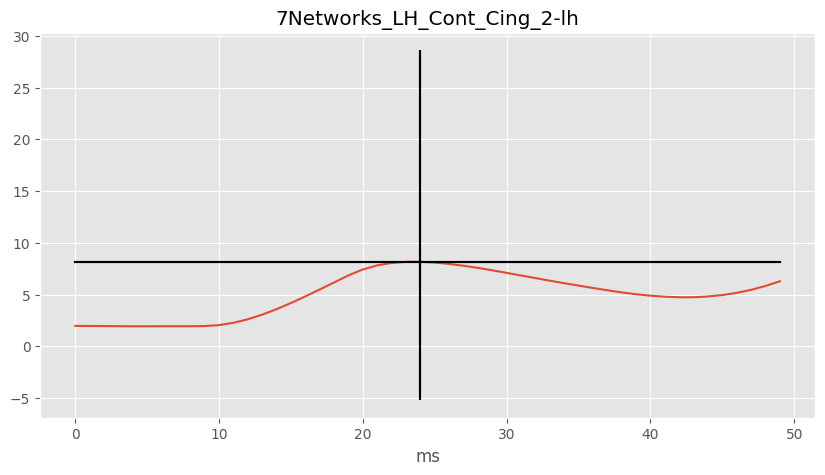

In [769]:
roi_idx = 1

amp_id, amp, amp_h_id, amp_h = peak_analysis(data_ts_croped[:,roi_idx],threshold=8)


plot_one_roi(data_ts_croped,roi_idx,labels=data_pytepfit['labels'],constants_h=[amp,amp_h],constants_v=[amp_id,amp_h_id])

In [770]:
responses = {} 
stim_time = 100

df_responses = pd.DataFrame()

thr_range = get_threshold_range(data_ts,stim_time)
list_of_thresholds = []

for threshold in thr_range:

    response_df = pd.DataFrame(index=range(200))

    response_df['01-response'] =  np.where(np.max(data_ts_croped,axis=0) > threshold,1,0)

    peak_analysis_results = np.zeros((200,4),dtype=float)
    for i in range(200):
        peak_analysis_results[i] = peak_analysis(data_ts_croped[:,i],threshold)

    response_df['first_peak'] = peak_analysis_results[:,0]
    response_df['first_peak_time'] = peak_analysis_results[:,1]
    response_df['highest_peak'] = peak_analysis_results[:,2]
    response_df['highest_peak_time'] = peak_analysis_results[:,3]

    response_df['variance'] = np.var(data_ts_croped,axis=0)
    response_df['diff'] = np.max(data_ts_croped,axis=0)-np.min(data_ts_croped,axis=0)

    response_df['AUC'] = np.array([sk_metrics.auc(list(range(len(data_ts_croped[:,i]))), data_ts_croped[:,i]) for i in range(200)],dtype=float)
    response_df['AUC_curve_above_thr'] = np.array([sk_metrics.auc(list(range(len(data_ts_croped[:,i]))), (data_ts_croped[:,i]-threshold).clip(min=0)) for i in range(200)],dtype=float)
    response_df['mean'] = np.array([np.mean(data_ts_croped[:,i]) for i in range(200)],dtype=float)
    response_df['power'] = np.array([np.sum(data_ts_croped[:,i]**2) for i in range(200)],dtype=float)

    for c in ['variance','diff','AUC','AUC_curve_above_thr','mean','power']:
        response_df[c] = np.where(response_df['01-response'],response_df[c],WHEN_NOT_OVER_THRESHOLD)

    responses[threshold] = response_df
    list_of_thresholds.append(threshold)

(200,)


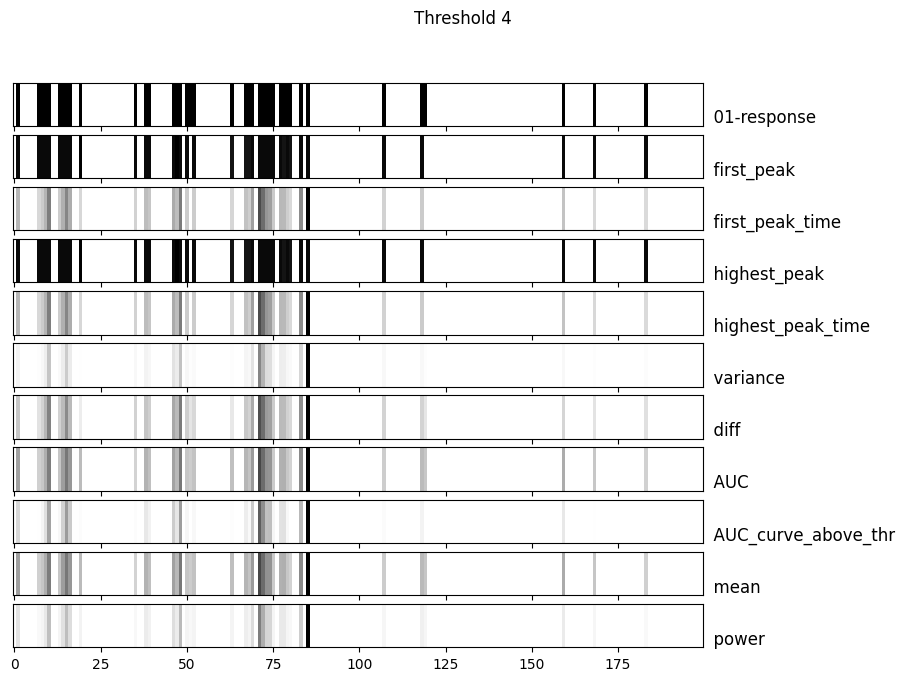

In [771]:
thr = list_of_thresholds[2]

fig, axs = plotting.prepare_barcode(len(responses[thr].columns),200,title=f"Threshold {thr}")


for i,c in enumerate(responses[thr].columns):
    plotting.plot_one_barcode(axs[i],responses[thr][c],title=c)

In [772]:
stim_locatin = 85 # we know this from previous notebooks

### Load structural connectivity data

In [773]:
SC_matrices = data.load_set_of_schaefer_matrices_for_pytepfit()

SC_matrices_filtered = []

for i, stat_data in enumerate(SC_matrices):
    name, SC_W, SC_L, SC_W_log = stat_data
    pivot = matrix_filtering.find_pivot_to_keep_xpercent_edges(SC_W,GRAPH_DENSITY)
    SC_W = np.where(SC_W>=pivot,SC_W,0)
    if SC_L is not None:
        SC_L = np.where(SC_W>=pivot,SC_L,np.nan)
    SC_W_log = np.where(SC_W>=pivot,SC_W_log,np.nan)
    SC_matrices_filtered.append((name, SC_W, SC_L, SC_W_log))

SC_matrices = SC_matrices_filtered

/home/katterrina/fi_muni/0_diplomka/src/data.py:134: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append(("PyTepFit_simple",SC_W_pytep, SC_L_pytep,np.log(SC_W_pytep)))
/home/katterrina/fi_muni/0_diplomka/src/data.py:55: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append((f"{dataset_name}_{mode}",SC_W, SC_L,np.log(SC_W)))
/home/katterrina/fi_muni/0_diplomka/src/data.py:55: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append((f"{dataset_name}_{mode}",SC_W, SC_L,np.log(SC_W)))


In [774]:
centroids_file = paths.path('external/schaefer_parcellation_centroids/ROI_MAPPING_pytepfit.csv')
centroids_mne = data.get_centroids_from_file(centroids_file,"geom_mne")

ED = data.roi_distances_from_centroids(centroids_mne)

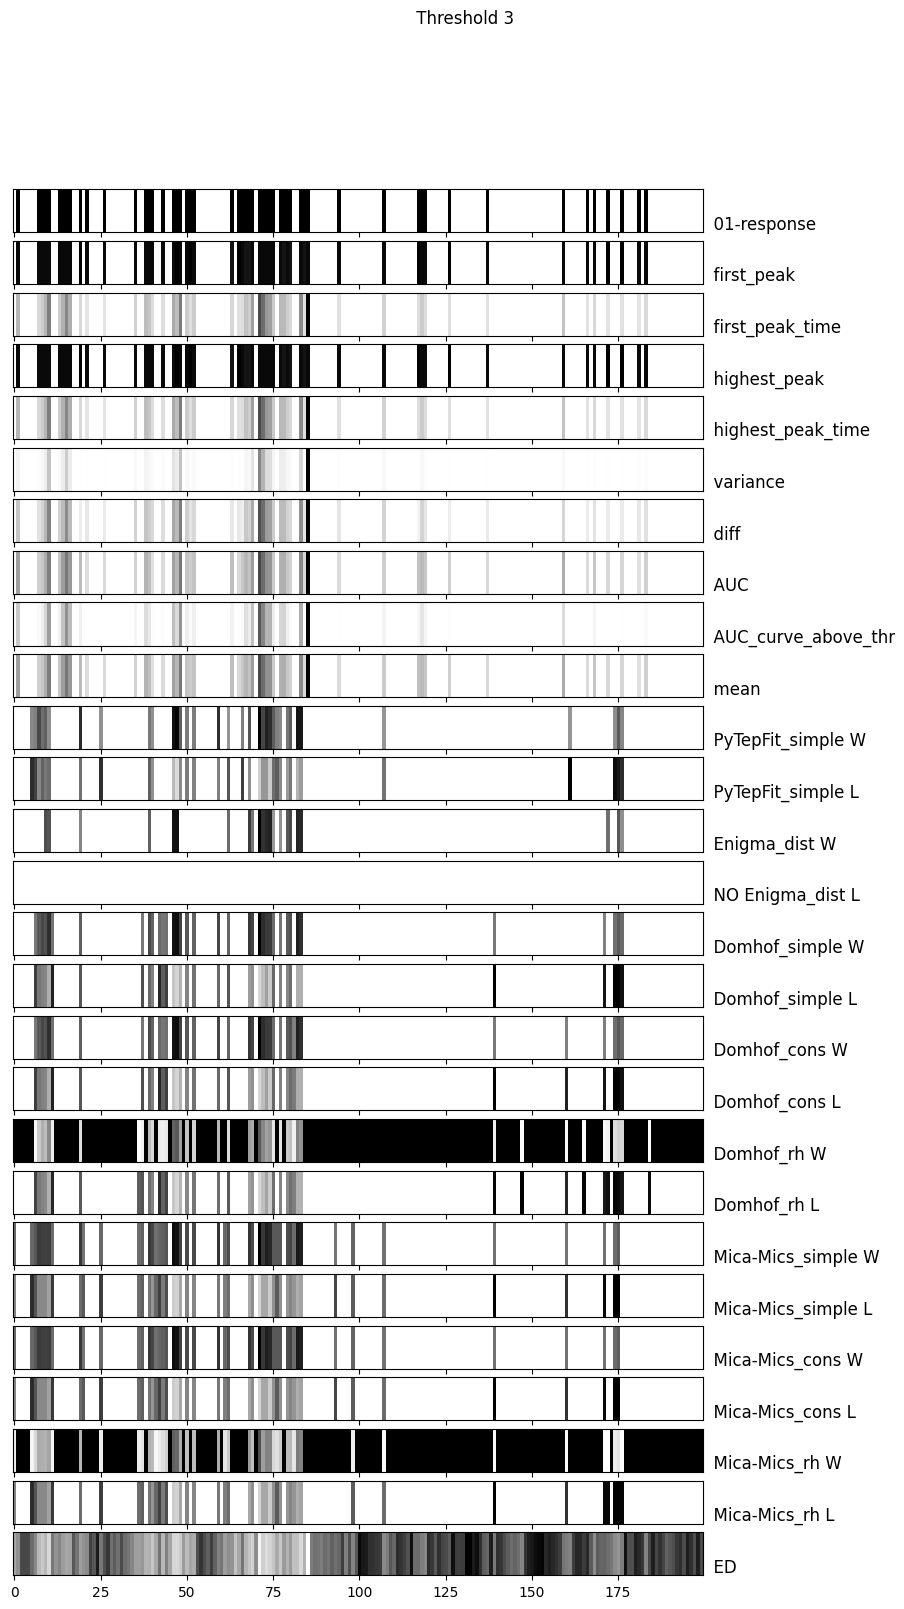

In [775]:
thr = list_of_thresholds[1]
n_of_response_def = len(responses[thr].columns)

fig, axs = plotting.prepare_barcode(n_of_response_def+2*len(SC_matrices),200, title = f" Threshold {thr}")

for i,c in enumerate(responses[thr].columns):
    plotting.plot_one_barcode(axs[i],responses[thr][c],title=c)

for j,d in enumerate(SC_matrices):
    name, SC_W,SC_L,SC_W_log = d
    plotting.plot_one_barcode(axs[i+2*j],SC_W_log[stim_locatin],title=f"{name} W")
    if SC_L is not None:
        plotting.plot_one_barcode(axs[i+2*j+1],SC_L[stim_locatin],title=f"{name} L")
    else:
        z = np.zeros(SC_W_log[stim_locatin].shape)
        plotting.plot_one_barcode(axs[i+2*j+1],z,title=f"NO {name} L")

plotting.plot_one_barcode(axs[-1],ED[stim_locatin],title=f"ED")
plt.savefig(paths.path_figures(fig_dir+"barcode.pdf"),bbox_inches='tight',pad_inches=0)

In [776]:
all_responses = pd.concat(responses)
all_responses

01-response  first_peak  first_peak_time  highest_peak  \
2 0              0         NaN              NaN           NaN   
  1              1        24.0         8.172069          24.0   
  2              0         NaN              NaN           NaN   
  3              0         NaN              NaN           NaN   
  4              0         NaN              NaN           NaN   
...            ...         ...              ...           ...   
7 195            0         NaN              NaN           NaN   
  196            0         NaN              NaN           NaN   
  197            0         NaN              NaN           NaN   
  198            0         NaN              NaN           NaN   
  199            0         NaN              NaN           NaN   

       highest_peak_time  variance      diff         AUC  AUC_curve_above_thr  \
2 0                  NaN       NaN       NaN         NaN                  NaN   
  1             8.172069  4.508034  6.233756  246.839752           149.307066   
  2                  NaN       NaN       NaN         NaN                  NaN   
  3                  NaN       NaN       NaN         NaN                  NaN   
  4                  NaN       NaN       NaN         NaN                  NaN   
...                  ...       ...       ...         ...                  ...   
7 195                NaN       NaN       NaN         NaN                  NaN   
  196                NaN       NaN       NaN         NaN                  NaN   
  197                NaN       NaN       NaN         NaN                  NaN   
  198                NaN       NaN       NaN         NaN                  NaN   
  199                NaN       NaN       NaN         NaN                  NaN   

           mean        power  
2 0         NaN          NaN  
  1    5.019454  1485.147461  
  2         NaN          NaN  
  3         NaN          NaN  
  4         NaN          NaN  
...         ...          ...  
7 195       NaN          NaN  
  196       NaN          NaN  
  197       NaN          NaN  
  198       NaN          NaN  
  199       NaN          NaN  

[1200 rows x 11 columns]

## One selected SC matrix

Select Mica-Mics structural with RH preprocessing, because we already know that it results into correlations for F-Tract.

In [777]:
for i, m in enumerate(SC_matrices):
    print(i, m[0])

0 PyTepFit_simple
1 Enigma_dist
2 Domhof_simple
3 Domhof_cons
4 Domhof_rh
5 Mica-Mics_simple
6 Mica-Mics_cons
7 Mica-Mics_rh


In [778]:
for i, m in enumerate(SC_matrices):
    if SELECTED_SC_MATRIX == m[0]:
        name, SC_W, SC_L, SC_W_log = m
        print(name)


Mica-Mics_rh


## Correlations

In [779]:
def select_response_by_definition(definition,rdict):
    new_df = pd.DataFrame()
    for thr in rdict.keys():
        new_df[f"{thr:02d}"] = rdict[thr][definition]
    
    return new_df  

In [780]:
def plot_df_as_heatmap(df,x_axis,y_axis,value,x_label="threshold",y_label="",p=None,title=None,ax=None):
    plt.figure(figsize=(8,8))
    pivot = df.pivot_table(index=x_axis, columns=y_axis, values=value,sort=False)
    if p is not None:
        pivot_p = df.pivot_table(index=x_axis, columns=y_axis, values=p,sort=False)
        pivot = pivot.where(pivot_p < 0.05)

    cmap = LinearSegmentedColormap.from_list('', ['#FF2200', 'white', '#FF2200'])# 'seismic'

    if ax is not None:
        sns.heatmap(pivot, annot=True,center=0,cmap=cmap,vmin=-1, vmax=1,ax=ax,square=True,cbar=False)
    else:
        ax = sns.heatmap(pivot, annot=True,center=0,cmap=cmap,vmin=-1, vmax=1,ax=ax,square=True,cbar=False)
    ax.set_title(title)
    ax.set(xlabel=x_label)
    ax.set(ylabel=y_label)
    plt.yticks(rotation=0) 
    plt.savefig(paths.path_figures(fig_dir+title+".pdf"),bbox_inches='tight',pad_inches=0)
    plt.show()

def corr_columns_of_two_matrices(responses_by_threshold,metrics):

    col_names_thresholds = list(responses_by_threshold.keys())
    col_names_SC = list(metrics.keys())

    df = pd.concat([responses_by_threshold,metrics], axis=1, join="inner")

    stat_pg = pg.pairwise_corr(df,columns=[col_names_thresholds,col_names_SC],method="spearman").round(3)

    return stat_pg

In [781]:
com_metrics_matrices = communicatin_metrics.calculate_communicatin_metrics(ED,SC_L,SC_W)

dict_metrics = {}
for c in com_metrics_matrices:
    dict_metrics[c] = com_metrics_matrices[c][stim_locatin]

df_metrics = pd.DataFrame(dict_metrics)
df_metrics

/home/katterrina/fi_muni/0_diplomka/src/communicatin_metrics.py:23: RuntimeWarning: divide by zero encountered in divide
  metrics_dict["SPE"] = np.divide(1,shortest_paths)
/home/katterrina/fi_muni/0_diplomka/src/communicatin_metrics.py:26: RuntimeWarning: divide by zero encountered in divide
  shortest_paths,_ = metrics.distance_wei_floyd(1/SC_W)
/home/katterrina/fi_muni/0_diplomka/src/communicatin_metrics.py:27: RuntimeWarning: divide by zero encountered in divide
  metrics_dict["SPE_W"] = np.divide(1,shortest_paths)


/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:553: RuntimeWarning: divide by zero encountered in log2
  SI[i, j] = -np.log2(np.prod(pr_step_ff))
/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:554: RuntimeWarning: divide by zero encountered in log2
  SI[j, i] = -np.log2(np.prod(pr_step_bk))
/home/katterrina/fi_muni/0_diplomka/src/communicatin_metrics.py:47: RuntimeWarning: divide by zero encountered in divide
  metrics_dict["NAV"] = np.divide(1,nav_paths)
/home/katterrina/fi_muni/0_diplomka/__venv__/lib/python3.10/site-packages/netneurotools/metrics.py:781: RuntimeWarning: divide by zero encountered in divide
  E_diff = np.divide(1, mfpt)


,ED,SC_W,SC_L,SPE,SPE_W,COM,SI,SI_L,NAV,DIF
0,45.307805,0.001481,56.91748,0.017569,0.009146,0.005899,8.492163,8.492163,0.017569,0.004902
1,56.289608,0.000000,inf,0.012035,0.007808,0.001445,inf,13.765920,0.008938,0.003926
2,92.766248,0.000000,inf,0.008308,0.006559,0.000284,inf,13.524316,0.006877,0.002492
3,94.172221,0.000000,inf,0.008227,0.007810,0.001046,inf,15.620317,0.008135,0.004036
4,92.564602,0.000000,inf,0.008065,0.007312,0.000696,inf,12.555779,0.008065,0.003484
...,...,...,...,...,...,...,...,...,...,...
195,115.547602,0.000000,inf,0.006240,0.004349,0.000006,inf,24.493235,0.004887,0.003644
196,105.548873,0.000000,inf,0.006381,0.004389,0.000011,inf,22.163802,0.003238,0.003574
197,90.633878,0.000000,inf,0.009385,0.005021,0.000052,inf,15.122497,0.009385,0.002838
198,114.749213,0.000000,inf,0.006213,0.004343,0.000007,inf,23.728181,0.004536,0.003356


0it [00:00, ?it/s]

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,02,ED,spearman,two-sided,200,-0.442,"[-0.55, -0.32]",0.000,1.000
1,02,SC_W,spearman,two-sided,200,0.333,"[0.2, 0.45]",0.000,0.998
2,02,SC_L,spearman,two-sided,200,-0.344,"[-0.46, -0.22]",0.000,0.999
3,02,SPE,spearman,two-sided,200,0.403,"[0.28, 0.51]",0.000,1.000
4,02,SPE_W,spearman,two-sided,200,0.385,"[0.26, 0.5]",0.000,1.000
5,02,COM,spearman,two-sided,200,0.346,"[0.22, 0.46]",0.000,0.999
6,02,SI,spearman,two-sided,199,-0.338,"[-0.46, -0.21]",0.000,0.999
7,02,SI_L,spearman,two-sided,199,-0.345,"[-0.46, -0.22]",0.000,0.999
8,02,NAV,spearman,two-sided,200,0.423,"[0.3, 0.53]",0.000,1.000
9,02,DIF,spearman,two-sided,200,0.111,"[-0.03, 0.25]",0.118,0.346


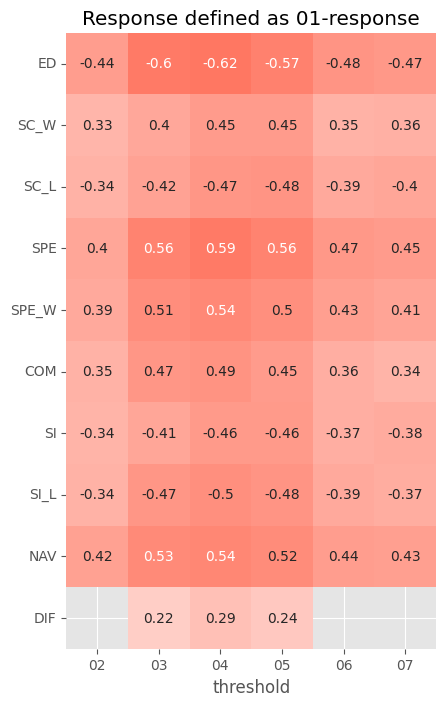

1it [00:00,  1.33it/s]

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,02,ED,spearman,two-sided,76,0.154,"[-0.07, 0.37]",0.183,0.267
1,02,SC_W,spearman,two-sided,76,-0.029,"[-0.25, 0.2]",0.800,0.057
2,02,SC_L,spearman,two-sided,76,0.076,"[-0.15, 0.3]",0.517,0.099
3,02,SPE,spearman,two-sided,76,-0.195,"[-0.4, 0.03]",0.092,0.396
4,02,SPE_W,spearman,two-sided,76,-0.240,"[-0.44, -0.01]",0.037,0.555
5,02,COM,spearman,two-sided,76,-0.078,"[-0.3, 0.15]",0.503,0.103
6,02,SI,spearman,two-sided,75,0.052,"[-0.18, 0.28]",0.656,0.073
7,02,SI_L,spearman,two-sided,75,0.177,"[-0.05, 0.39]",0.129,0.332
8,02,NAV,spearman,two-sided,76,-0.177,"[-0.39, 0.05]",0.126,0.337
9,02,DIF,spearman,two-sided,76,-0.245,"[-0.45, -0.02]",0.033,0.576


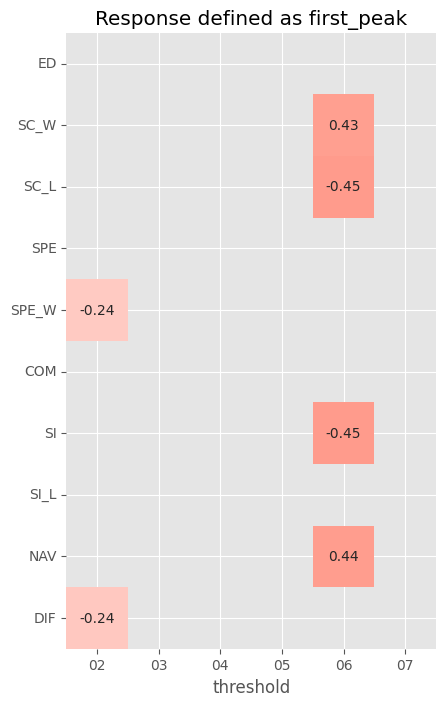

2it [00:01,  1.61it/s]

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,02,ED,spearman,two-sided,76,-0.635,"[-0.75, -0.48]",0.000,1.000
1,02,SC_W,spearman,two-sided,76,0.398,"[0.19, 0.57]",0.000,0.952
2,02,SC_L,spearman,two-sided,76,-0.376,"[-0.55, -0.16]",0.001,0.924
3,02,SPE,spearman,two-sided,76,0.614,"[0.45, 0.74]",0.000,1.000
4,02,SPE_W,spearman,two-sided,76,0.507,"[0.32, 0.66]",0.000,0.998
5,02,COM,spearman,two-sided,76,0.563,"[0.39, 0.7]",0.000,1.000
6,02,SI,spearman,two-sided,75,-0.391,"[-0.57, -0.18]",0.001,0.941
7,02,SI_L,spearman,two-sided,75,-0.508,"[-0.66, -0.32]",0.000,0.998
8,02,NAV,spearman,two-sided,76,0.538,"[0.36, 0.68]",0.000,0.999
9,02,DIF,spearman,two-sided,76,0.240,"[0.02, 0.44]",0.036,0.559


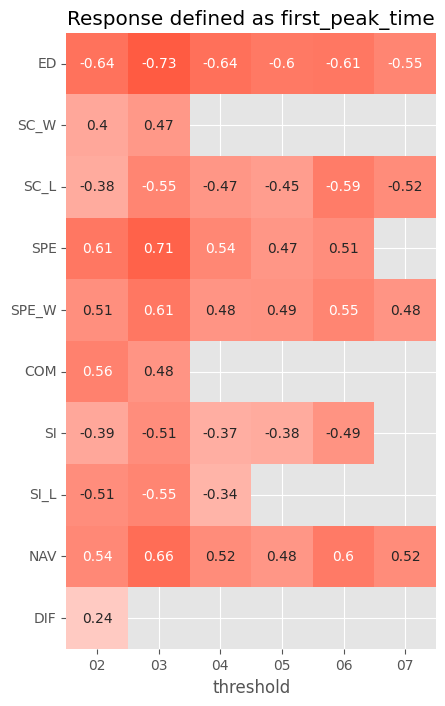

3it [00:01,  1.56it/s]

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,02,ED,spearman,two-sided,76,0.110,"[-0.12, 0.33]",0.342,0.158
1,02,SC_W,spearman,two-sided,76,0.010,"[-0.22, 0.24]",0.928,0.051
2,02,SC_L,spearman,two-sided,76,0.007,"[-0.22, 0.23]",0.949,0.050
3,02,SPE,spearman,two-sided,76,-0.131,"[-0.35, 0.1]",0.260,0.204
4,02,SPE_W,spearman,two-sided,76,-0.199,"[-0.41, 0.03]",0.085,0.410
5,02,COM,spearman,two-sided,76,-0.101,"[-0.32, 0.13]",0.387,0.140
6,02,SI,spearman,two-sided,75,-0.010,"[-0.24, 0.22]",0.932,0.051
7,02,SI_L,spearman,two-sided,75,0.098,"[-0.13, 0.32]",0.405,0.133
8,02,NAV,spearman,two-sided,76,-0.079,"[-0.3, 0.15]",0.496,0.105
9,02,DIF,spearman,two-sided,76,-0.137,"[-0.35, 0.09]",0.239,0.219


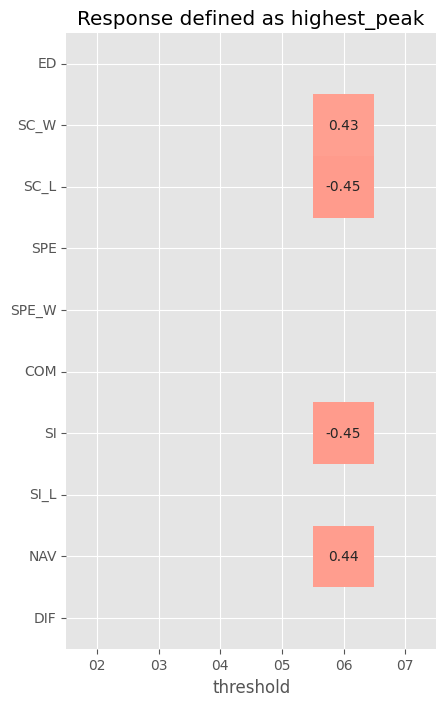

4it [00:02,  1.75it/s]

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,02,ED,spearman,two-sided,76,-0.816,"[-0.88, -0.72]",0.000,1.000
1,02,SC_W,spearman,two-sided,76,0.482,"[0.29, 0.64]",0.000,0.995
2,02,SC_L,spearman,two-sided,76,-0.552,"[-0.69, -0.37]",0.000,1.000
3,02,SPE,spearman,two-sided,76,0.787,"[0.68, 0.86]",0.000,1.000
4,02,SPE_W,spearman,two-sided,76,0.685,"[0.54, 0.79]",0.000,1.000
5,02,COM,spearman,two-sided,76,0.592,"[0.42, 0.72]",0.000,1.000
6,02,SI,spearman,two-sided,75,-0.514,"[-0.66, -0.33]",0.000,0.998
7,02,SI_L,spearman,two-sided,75,-0.645,"[-0.76, -0.49]",0.000,1.000
8,02,NAV,spearman,two-sided,76,0.728,"[0.6, 0.82]",0.000,1.000
9,02,DIF,spearman,two-sided,76,0.322,"[0.1, 0.51]",0.005,0.818


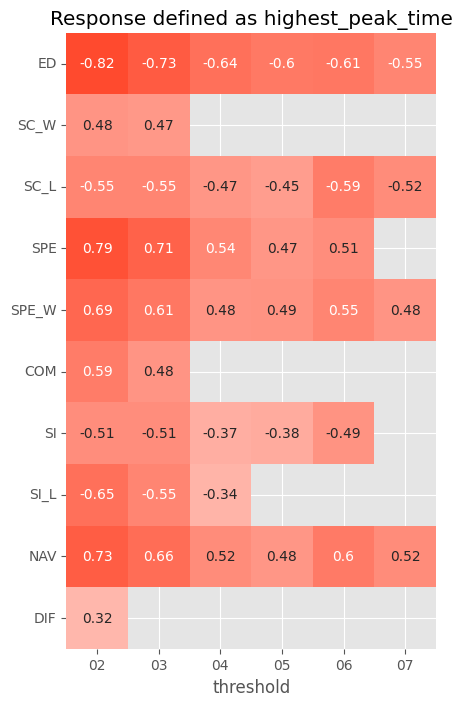

5it [00:02,  1.76it/s]

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,02,ED,spearman,two-sided,82,-0.749,"[-0.83, -0.64]",0.000,1.000
1,02,SC_W,spearman,two-sided,82,0.388,"[0.19, 0.56]",0.000,0.955
2,02,SC_L,spearman,two-sided,82,-0.446,"[-0.6, -0.25]",0.000,0.990
3,02,SPE,spearman,two-sided,82,0.705,"[0.58, 0.8]",0.000,1.000
4,02,SPE_W,spearman,two-sided,82,0.602,"[0.44, 0.72]",0.000,1.000
5,02,COM,spearman,two-sided,82,0.513,"[0.33, 0.66]",0.000,0.999
6,02,SI,spearman,two-sided,81,-0.415,"[-0.58, -0.22]",0.000,0.975
7,02,SI_L,spearman,two-sided,81,-0.557,"[-0.69, -0.39]",0.000,1.000
8,02,NAV,spearman,two-sided,82,0.638,"[0.49, 0.75]",0.000,1.000
9,02,DIF,spearman,two-sided,82,0.305,"[0.09, 0.49]",0.005,0.804


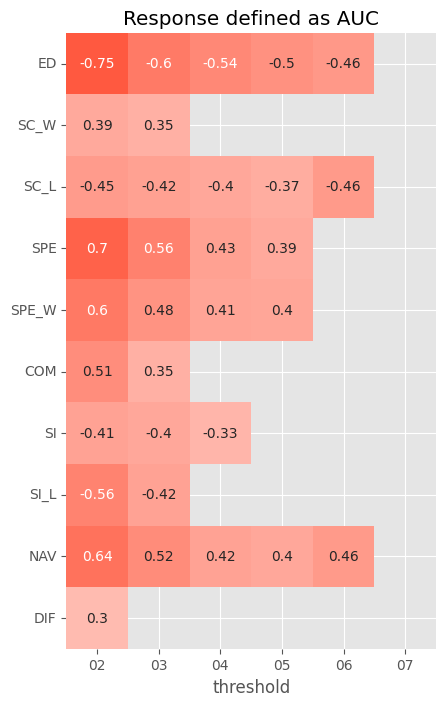

6it [00:03,  1.72it/s]


In [782]:
selected_response_definitions= ['01-response', 'first_peak', 'first_peak_time', 'highest_peak', 'highest_peak_time', 'AUC']
#pd.set_option('display.max_rows', None)

plt.style.use('ggplot')
for i,resp_definition in tqdm(enumerate(selected_response_definitions)):
    responses_df = select_response_by_definition(resp_definition,responses)  
    
    df = corr_columns_of_two_matrices(responses_df,df_metrics)
        
    display(df)
    
    plot_df_as_heatmap(df,"Y","X","r",p="p-unc",title=f"Response defined as {resp_definition}")


In [783]:
df_metrics['label'] = data_pytepfit['labels']

df_metrics_AUC = df_metrics.copy()
df_metrics_01 = df_metrics.copy()

for thr in list(responses.keys()):
    df_metrics_AUC["response"] = responses[thr]["AUC"]
    df_metrics_01["response"] = responses[thr]["01-response"]
    df_metrics_AUC_id = df_metrics_AUC.set_index('label')
    df_metrics_01_id = df_metrics_01.set_index('label')
    df_metrics_AUC_id.to_csv(paths.path(f'{results_dir}response_AUC_and_communication_metrics_M1_pyTepFit_{RESPONSE_LENGTH}ms_thr{thr}.csv'))
    df_metrics_01_id.to_csv(paths.path(f'{results_dir}response_01_and_communication_metrics_M1_pyTepFit_{RESPONSE_LENGTH}ms_thr{thr}.csv'))